### All of our necessary imports go here, with optional aliases.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Local variables can be defined here.

In [39]:
path_to_data: str = '../data/raw/diabetes.csv'
remove_zeros_from_these_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

### Production functions defined here.

In [40]:
def get_data(path_to_data):
    """Docstring"""
    
    df = pd.read_csv(path_to_data) #add params here
    return df

def show_dist_figs(dataframe, column_name: str, num_bins=20) -> None:
    # Takes a pandas df and a certain column and displays a boxplot and histogram. Returns None.
    
    sns.boxplot(data=df[column_name], orient='h').set(xlabel=column_name)
    plt.show()
    sns.histplot(data=df[column_name], kde=True, bins = num_bins)
    plt.show()
    return None
    

In [41]:
df = get_data(path_to_data)

At this point, we can begin cleaning, EDA, and feature engineering. Let's look for:
### Cleaning 
1. Missing values, zeroes, and NaNs.
2. Outliers or values outside of 3 sigma.
3. Type errors, encoding errors, etc.
4. Duplicates, if any.

### EDA
1. Correlational matrix (which features best predict the label?).
2. Is there skew or kurtosis in the feature distribution?
3. Understanding features holistically (what does 'skin thickness' or 'pedigree' mean?).

### Feature Engineering
1. Imputation of missing values, zeroes, NaNs.   
    a. Median method.  
    b. KNN cluster analysis method.
2. Creation of new, derivative features.
    a. Branch the dataset at this point so that one can be used for an ANN and the other for ensemble.
3. Scaling, capping, etc.

In [42]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Let's introduce some cleaning functions.

In [43]:
def zeroes_exist(dataframe) -> bool:
    # Check if zeroes in either flt or int form exist. Prints type of zero and returns boolean.
    if 0 in dataframe.values or 0.0 in dataframe.values:
        if 0 in dataframe.values:
            print("Int-type 0 found in dataset")
            return True
        else:
            print("Float-type 0.0 found in dataset")
            return True
    else:
        return False

In [44]:
def NaNs_exist(dataframe) -> bool:
    return dataframe.isnull().values.any()

In [45]:
def count_zeroes(dataframe, column_header) -> int:
    # Takes in a dataframe and a column name and returns number of zeroes (float and int)
    if 0 in dataframe[column_header].values: # If it has no zeroes
        count = dataframe[column_header].value_counts()[0]
        return count
    else:
        return 0
        
        

In [46]:
def summarize_zeroes(dataframe) -> dict:
    # Takes in a dataframe and returns a dict that maps feature names to number of missing values.
    zeroes_dict = {}
    for header in dataframe.columns:
        num_zeroes = count_zeroes(dataframe, header)
        zeroes_dict[header] = num_zeroes
    return zeroes_dict

def plot_zeroes(dict_of_zeros):
    plt.bar(dict_of_zeros.keys(), dict_of_zeros.values())
    plt.xticks(rotation='vertical')
    plt.show()

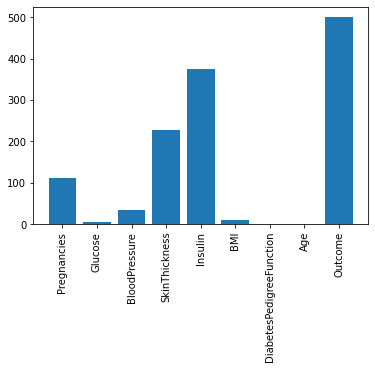

In [47]:
plot_zeroes(summarize_zeroes(df))

#### It's clear that there are zeros present in Glucose, Blood Pressure, Skin Thickness, Insulin, and BMI that should not be there. Let's begin by replacing those zeros with NumPy NaNs, that way Pandas understands that they are missing, not actual zero measurements.

In [48]:
def zeros_to_nans(dataframe,column_list) -> pd.DataFrame:
    dataframe[column_list] = dataframe[column_list].replace({'0':np.nan, 0:np.nan})
    return dataframe

df = zeros_to_nans(df, remove_zeros_from_these_columns)

#### Check that worked...

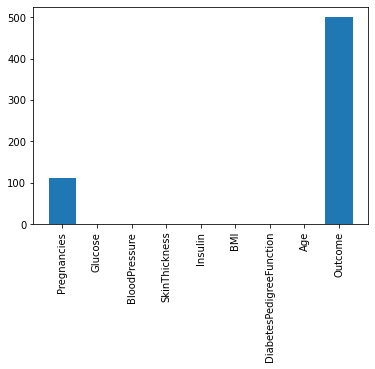

In [49]:
plot_zeroes(summarize_zeroes(df))

#### Time to look for outliers.

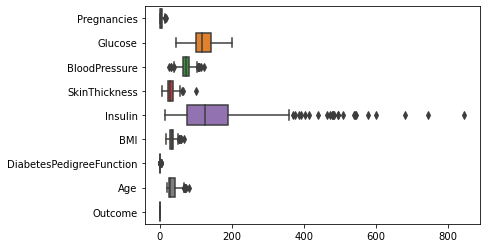

In [50]:
overall_box = sns.boxplot(data=df, orient='h')

#### Okay, let's step through this and make some design decisions.

In [51]:
def plot_outliers(dataframe, column_label):
    fig1 = sns.boxplot(data=dataframe[column_label], orient='h')
    fig2 = sns.histplot(data=dataframe[column_label], kde=True)
    return fig1, fig2

### Pregnancies

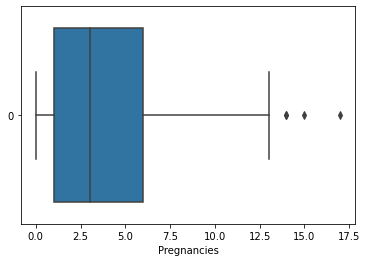

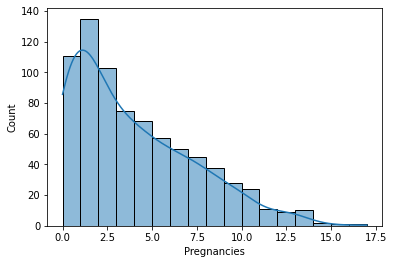

In [61]:
show_dist_figs(df,'Pregnancies',17)

#### This is an almost linear distribution, so in this case, we have a small number (3) of outliers that can likely be excluded. The edge of the whisker is at 1.5 sigma.

### Glucose

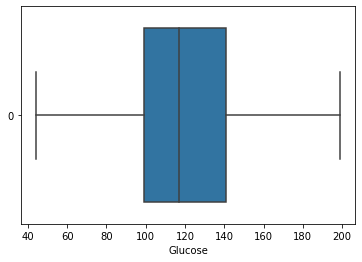

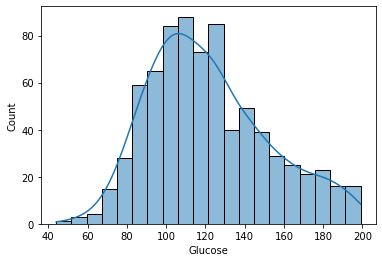

In [53]:
show_dist_figs(df,'Glucose')

#### This is exactly what would be expected, a somewhat normal distribution with a hump on the right for the diabetic set. No outliers found, I think this data shouldn't be trimmed of outliers.

### Blood Pressure

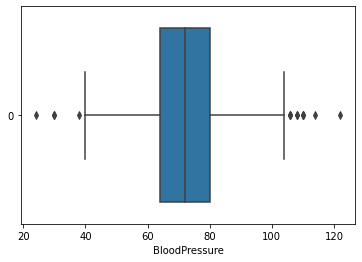

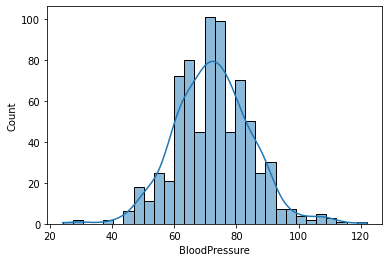

In [62]:
show_dist_figs(df,'BloodPressure',30)

### Skin Thickness

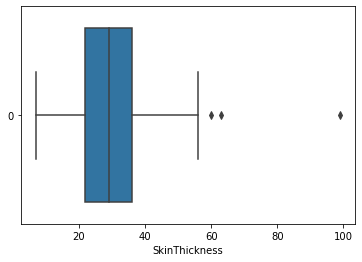

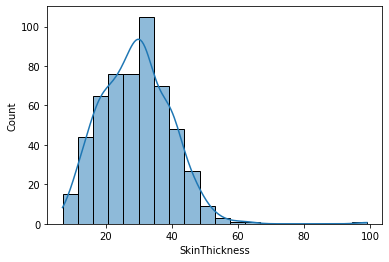

In [55]:
show_dist_figs(df,'SkinThickness')

#### Right-skew is evident here, very long tail. Outliers here are obvious.

### Insulin

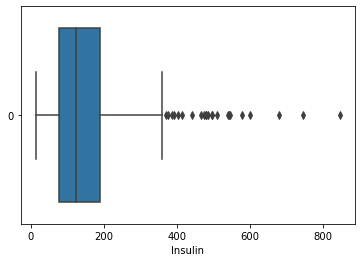

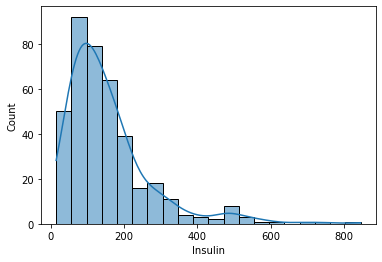

In [56]:
show_dist_figs(df,'Insulin')

#### OK, another right-skewed distribution. However, from medical principles, insulin is going to be predictive of diabetic status. If we do a scatterplot (multivariate outlier analysis) we should see a predictive effect:

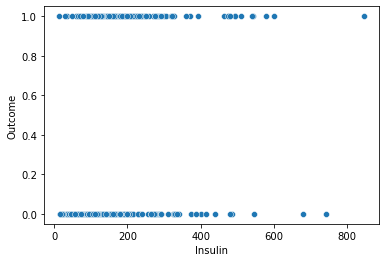

In [57]:
sns.scatterplot(data=df, x='Insulin', y='Outcome')
plt.show()

#### There seems to be a predictive cluster between 450 and 600 ng/dL insulin. However, it seems like we can set an outlier cut-off past 600.

### BMI

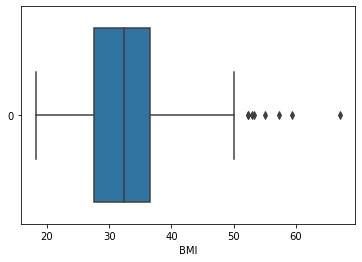

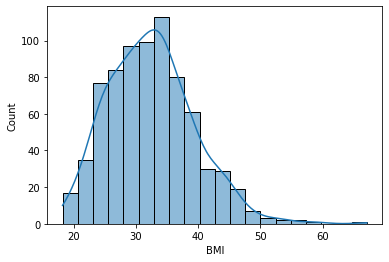

In [58]:
show_dist_figs(df,'BMI')

#### Right skew continues, and it seems as if Insulin, BMI, Skin Thickness can all be superimposed on each other with minimal loss. BMI being a function of Skin Thickness is totally unsurprising, but the link between Insulin (a molecule in the bloodstream) and BMI (a phenotype) is both scientifically and statistically interesting.